# AIP Assignment 1
## Q2. CNN based classifiers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
% cd /content/drive/MyDrive/Term2/AIP/Assignment1

/content/drive/MyDrive/Term2/AIP/Assignment1


## Import TensorFlow and other libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf
 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Prepare data

Organise the given data in the following folder structure to load and prepare data for model training

```
data/
  train/
    airplanes/
    bikes/
    cars/
    faces/
  test/
    airplanes/
    bikes/
    cars/
    faces/
```

In [5]:
train_dir = pathlib.Path('./data/train')
test_dir = pathlib.Path('./data/test')

batch_size = 32
img_height = 224
img_width = 224

print('Loading training data ...')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                       shuffle=True,
                                       image_size=(img_height, img_width),
                                       batch_size=batch_size)

print('Loading test data ...')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=80)

class_names = train_ds.class_names
num_classes = len(class_names)
print('\nClasses:', class_names)

Loading training data ...
Found 120 files belonging to 4 classes.
Loading test data ...
Found 80 files belonging to 4 classes.

Classes: ['airplanes', 'bikes', 'cars', 'faces']


### Visualize a few training data samples


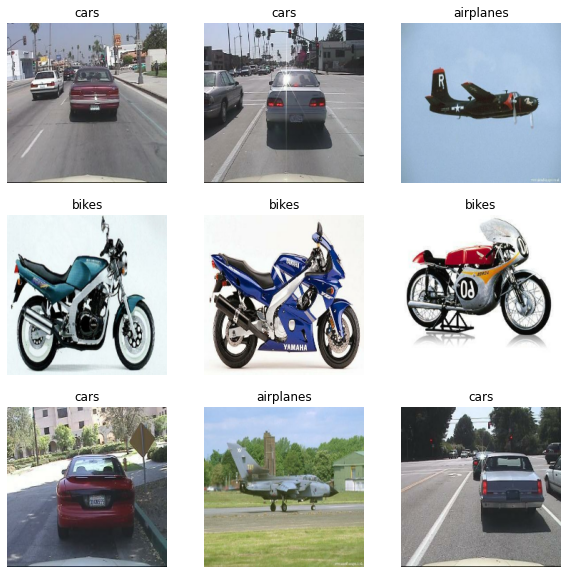

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)

# k-NN classifier using features from ImageNet pretrained VGG16 model

### Get feature extractor from VGG16 model trained on ImageNet data

In [7]:
def vgg16_feature_extractor():
  vgg16 = tf.keras.applications.VGG16()
  vgg16_features = tf.keras.Model(inputs=vgg16.input,
                                  outputs=vgg16.get_layer("fc2").output)
  vgg16_features.trainable = False
  return vgg16_features

### Gather features and labels from training data

In [8]:
train_features = []
train_labels =[]
train_data = list(train_ds.as_numpy_iterator())
vgg16_features = vgg16_feature_extractor()
for images, labels in train_data:
  preprocessed_input = tf.keras.applications.vgg16.preprocess_input(images)
  feature = vgg16_features.predict(preprocessed_input)
  train_features.extend(feature)
  train_labels.extend(labels)
train_dict = {"features":train_features, "labels":train_labels}

553467904/553467096 [==============================] - 4s 0us/step


### Evaluate kNN classifier on test data

In [9]:
test_images, test_labels = list(test_ds.as_numpy_iterator())[0]
preprocessed_input = tf.keras.applications.vgg16.preprocess_input(test_images)
test_feature = vgg16_features.predict(preprocessed_input)
k = 10                         # Set no. of neightbours to check: k= 1, 5, 10, 15
tp = np.zeros(num_classes)
nimages_per_class= 20
for i in range(test_labels.shape[0]):
    dist = np.linalg.norm(test_feature[i] - train_dict["features"], axis =1)
    idx = np.argsort(dist)[:k]
    top_k = [train_dict["labels"][i] for i in idx]
    d = {x:top_k.count(x) for x in top_k}
    d = sorted(d.items(), key=lambda x: x[1])
    pred_label = d[-1][0]
    true_label = test_labels[i]
    if pred_label == true_label:
        tp[true_label]+=1
class_acc = tp / nimages_per_class
print('Model: kNN classifier using ImageNet pretrained VGG16')
print('Class wise accuracy: ', class_acc*100)

Model: kNN classifier using ImageNet pretrained VGG16
Class wise accuracy:  [100. 100. 100. 100.]


# Classifier over features from VGG16 model

Functions to plot training logs and evaluating test data

In [10]:
def visualize_training_plots(history, epochs = 10):
  acc = history.history['accuracy']
  loss = history.history['loss']
  epochs_range = range(1, epochs+1)

  plt.figure()
  plt.subplot(2,1,1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training Accuracy')
  plt.figure()
  plt.subplot(2,1,2)
  plt.plot(epochs_range, loss, label='Training Loss', color='r')
  plt.legend(loc='lower right')
  plt.title('Training Loss')

  return

In [11]:
def eval_test(model, test_ds):
  test_imgs, test_labels = list(test_ds.as_numpy_iterator())[0]
  logits = model.predict(test_imgs)
  preds = np.argmax(logits, axis = 1)
  class_acc = np.zeros(num_classes)
  for i in range(num_classes):
    index = np.where(test_labels == i)
    class_labels = test_labels[index]
    class_preds = preds[index]
    class_acc[i] = np.sum(np.equal(class_labels, class_preds))/class_labels.shape[0]
  return [class_acc, np.mean(class_acc)]

### Model definition

In [12]:
def pretrained_classifier():
  #Get feature extractor from VGG16 model trained on ImageNet data
  vgg16 = tf.keras.applications.VGG16()
  vgg16_features = tf.keras.Model(inputs=vgg16.input,
                                  outputs=vgg16.get_layer("fc2").output)
  
  #Build a model adding 4 node classification layer over 'fc2' layer from VGG16
  vgg16_features.trainable = False
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = tf.keras.applications.vgg16.preprocess_input(inputs)
  x = vgg16_features(x, training=False)
  outputs = tf.keras.layers.Dense(4)(x)
  model = tf.keras.Model(inputs, outputs)

  return model

### Train Classification layer for VGG16 based feature extractor 

Training VGG based classifier ...
Epoch 1/10
4/4 [==============================] - 1s 130ms/step - loss: 0.9529 - accuracy: 0.6099
Epoch 2/10
4/4 [==============================] - 0s 122ms/step - loss: 0.0095 - accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 0s 122ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 0s 122ms/step - loss: 5.1946e-04 - accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 0s 128ms/step - loss: 1.5367e-04 - accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 0s 122ms/step - loss: 1.2947e-04 - accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 0s 127ms/step - loss: 7.2132e-05 - accuracy: 1.0000
Epoch 8/10
4/4 [==============================] - 0s 125ms/step - loss: 5.0466e-05 - accuracy: 1.0000
Epoch 9/10
4/4 [==============================] - 0s 128ms/step - loss: 4.3757e-05 - accuracy: 1.0000
Epoch 10/10
4/4 [==============================] - 0s 123ms/

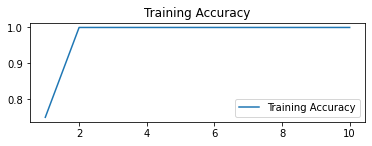

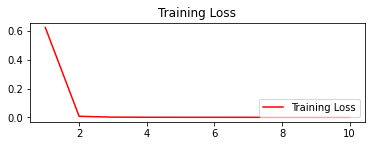

In [13]:
vgg16_model = pretrained_classifier()
vgg16_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print('Training VGG based classifier ...')
history = vgg16_model.fit(train_ds, epochs = 10)
visualize_training_plots(history, epochs = 10)

### Evaluate the model on test data

In [14]:
print('Evaluating on test set ...')
class_acc, acc = eval_test(vgg16_model, test_ds)
print('Model accuracy: ',acc*100)
print('Class wise accuracy: ', class_acc*100)

Evaluating on test set ...
Model accuracy:  100.0
Class wise accuracy:  [100. 100. 100. 100.]


#Models trained from scratch [Optional part]

### Define preprocessing layer for data augmentation during training

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)



### Model definition

In [19]:
def model1(num_classes = 4):
  model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Resizing(128, 128),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(num_classes)
  ])
  return model

def model2(num_classes = 4):
  model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Resizing(128, 128),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes)
  ])
  return model

### Train and evaluate model1 defined above
Feature vector dim = 4096

In [40]:
model = model1()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train model1

Epoch 1/40
4/4 [==============================] - 1s 29ms/step - loss: 1.3950 - accuracy: 0.2223
Epoch 2/40
4/4 [==============================] - 0s 27ms/step - loss: 1.3658 - accuracy: 0.2127
Epoch 3/40
4/4 [==============================] - 0s 19ms/step - loss: 1.3373 - accuracy: 0.3900
Epoch 4/40
4/4 [==============================] - 0s 21ms/step - loss: 1.2491 - accuracy: 0.3730
Epoch 5/40
4/4 [==============================] - 0s 18ms/step - loss: 1.0326 - accuracy: 0.5763
Epoch 6/40
4/4 [==============================] - 0s 18ms/step - loss: 0.7082 - accuracy: 0.7794
Epoch 7/40
4/4 [==============================] - 0s 18ms/step - loss: 0.5703 - accuracy: 0.7664
Epoch 8/40
4/4 [==============================] - 0s 18ms/step - loss: 0.5131 - accuracy: 0.8139
Epoch 9/40
4/4 [==============================] - 0s 18ms/step - loss: 0.4215 - accuracy: 0.8629
Epoch 10/40
4/4 [==============================] - 0s 18ms/step - loss: 0.4206 - accuracy: 0.8529
Epoch 11/40
4/4 [============

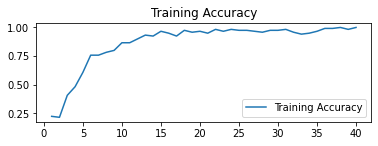

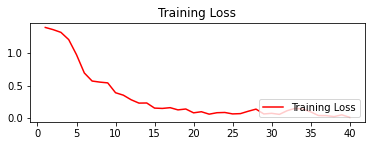

In [41]:
history = model.fit(train_ds, epochs = 40)
visualize_training_plots(history, epochs = 40)

In [42]:
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
resizing_11 (Resizing)       (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling_11 (Rescaling)     (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 32, 32, 32)      

#### Evaluate model1 on test data

In [43]:
print('Evaluating on test set ...')
class_acc, acc = eval_test(model, test_ds)
print('Model accuracy: ',acc)
print('Class wise accuracy: ', class_acc)

Evaluating on test set ...
Model accuracy:  0.9375
Class wise accuracy:  [0.85 1.   0.95 0.95]


### Train and evaluate model2 defined above
Feature vector dim = 256 (Global average pooling)

In [48]:
model = model2()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train model2

Epoch 1/40
4/4 [==============================] - 1s 31ms/step - loss: 1.4153 - accuracy: 0.2009
Epoch 2/40
4/4 [==============================] - 0s 29ms/step - loss: 1.3674 - accuracy: 0.2710
Epoch 3/40
4/4 [==============================] - 0s 22ms/step - loss: 1.3427 - accuracy: 0.2927
Epoch 4/40
4/4 [==============================] - 0s 20ms/step - loss: 1.2760 - accuracy: 0.4079
Epoch 5/40
4/4 [==============================] - 0s 18ms/step - loss: 1.1512 - accuracy: 0.4419
Epoch 6/40
4/4 [==============================] - 0s 19ms/step - loss: 1.0176 - accuracy: 0.6658
Epoch 7/40
4/4 [==============================] - 0s 18ms/step - loss: 0.9980 - accuracy: 0.5438
Epoch 8/40
4/4 [==============================] - 0s 18ms/step - loss: 0.8884 - accuracy: 0.6328
Epoch 9/40
4/4 [==============================] - 0s 19ms/step - loss: 0.7160 - accuracy: 0.7032
Epoch 10/40
4/4 [==============================] - 0s 18ms/step - loss: 0.7121 - accuracy: 0.6990
Epoch 11/40
4/4 [============

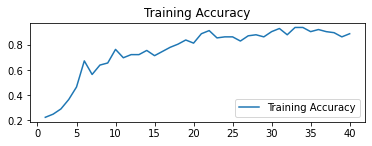

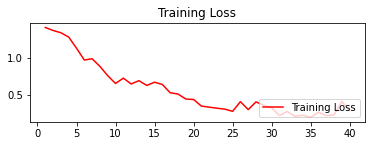

In [49]:
history = model.fit(train_ds, epochs = 40)
visualize_training_plots(history, epochs = 40)

In [50]:
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
resizing_14 (Resizing)       (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling_14 (Rescaling)     (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 32, 32, 32)      

#### Evaluate model2 on test data

In [51]:
print('Evaluating on test set ...')
class_acc, acc = eval_test(model, test_ds)
print('Model accuracy: ',acc)
print('Class wise accuracy: ', class_acc)

Evaluating on test set ...
Model accuracy:  0.85
Class wise accuracy:  [0.6  0.95 1.   0.85]
